# Importing the dependencies and reading the data

In [1]:
!pip install contractions -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.6 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import ast
import os
import re
from collections import defaultdict
import contractions

from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import mean_absolute_error, f1_score, precision_score, recall_score, classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBClassifier


from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv("/kaggle/input/multi-label-film-classifier/film_details.csv")
df.head()

,Title,Category,Url,Metascore,Number_of_critic_reviewers,User_score,Number_of_user_reviewers,Plot_summary,Genres
0,Dekalog (1988),movie,https://www.metacritic.com/movie/dekalog-1988/,100,13,100,112,This masterwork by Krzysztof Kieślowski is one...,['Drama']
1,The Godfather,movie,https://www.metacritic.com/movie/the-godfather/,100,16,100,4082,Francis Ford Coppola's epic features Marlon Br...,"['Crime', 'Drama']"
2,Lawrence of Arabia (re-release),movie,https://www.metacritic.com/movie/lawrence-of-a...,100,8,100,442,The 40th anniversary re-release of David Lean'...,"['Adventure', 'Biography', 'Drama', 'War']"
3,The Leopard (re-release),movie,https://www.metacritic.com/movie/the-leopard-r...,100,12,100,84,"Set in Sicily in 1860, Luchino Visconti's spec...","['Drama', 'History']"
4,The Conformist,movie,https://www.metacritic.com/movie/the-conformis...,100,11,100,105,"Set in Rome in the 1930s, this re-release of B...",['Drama']


In [4]:
# Keeping the relevant columns only

df = df[["Title", "Plot_summary", "Genres"]]  
df.head()

,Title,Plot_summary,Genres
0,Dekalog (1988),This masterwork by Krzysztof Kieślowski is one...,['Drama']
1,The Godfather,Francis Ford Coppola's epic features Marlon Br...,"['Crime', 'Drama']"
2,Lawrence of Arabia (re-release),The 40th anniversary re-release of David Lean'...,"['Adventure', 'Biography', 'Drama', 'War']"
3,The Leopard (re-release),"Set in Sicily in 1860, Luchino Visconti's spec...","['Drama', 'History']"
4,The Conformist,"Set in Rome in the 1930s, this re-release of B...",['Drama']


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

Title           0
Plot_summary    0
Genres          0
dtype: int64

In [6]:
# Check for completely empty rows
empty_rows = df[df.isnull().all(axis=1)]
print(f"\nNumber of completely empty rows: {len(empty_rows)}")


Number of completely empty rows: 0


### Observation: No Null/Empty value exists in the dataset

# Text preprocessing

In [7]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()               # Lowercase the text    
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags (if any)
    text = re.sub(r'\s+', ' ', text)  # Replace non-breaking spaces and special whitespace with regular space    
    text = text.strip()               # Strip leading/trailing whitespace
    return text


def remove_illegal_excel_chars(text):
    if isinstance(text, str):
        # Removes all control characters except for \t (tab), \n (newline), and \r (carriage return)
        return re.sub(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]', '', text)
    return text


df['Plot_summary'] = df['Plot_summary'].apply(clean_text)
df

for col in df.select_dtypes(include='object').columns: # Apply to all object (text) columns
    df[col] = df[col].apply(remove_illegal_excel_chars)

# Exploratory Data Analysis (EDA)

In [8]:
# Word & Character Counts
df['word_count'] = df['Plot_summary'].apply(lambda x: len(word_tokenize(x)))
df['char_count'] = df['Plot_summary'].apply(len)

# Sentence Count (for avg sentence length)
df['sentence_count'] = df['Plot_summary'].apply(lambda x: len(sent_tokenize(x)))

# Vocabulary size (entire dataset)
all_words = [word.lower() for text in df['Plot_summary'] for word in word_tokenize(text)]
vocab_size = len(set(all_words))

print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 43311


In [9]:
df

,Title,Plot_summary,Genres,word_count,char_count,sentence_count
0,Dekalog (1988),this masterwork by krzysztof kieślowski is one...,['Drama'],55,342,2
1,The Godfather,francis ford coppola's epic features marlon br...,"['Crime', 'Drama']",60,342,2
2,Lawrence of Arabia (re-release),the 40th anniversary re-release of david lean'...,"['Adventure', 'Biography', 'Drama', 'War']",25,144,1
3,The Leopard (re-release),"set in sicily in 1860, luchino visconti's spec...","['Drama', 'History']",44,242,2
4,The Conformist,"set in rome in the 1930s, this re-release of b...",['Drama'],43,249,1
...,...,...,...,...,...,...
15149,Cavemen,"cavemen revolves around joel, his younger brot...","['Comedy', 'Sci-Fi']",67,342,4
15150,Work It,"after they are laid off, lee standish (ben kol...",['Comedy'],35,151,1
15151,Category 7: The End of the World,"""category 7: the end of the world"" picks up wh...","['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Th...",72,340,3
15152,Stalker,lt. beth davis (maggie q) leads the threat ass...,"['Crime', 'Drama', 'Thriller']",49,233,4


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


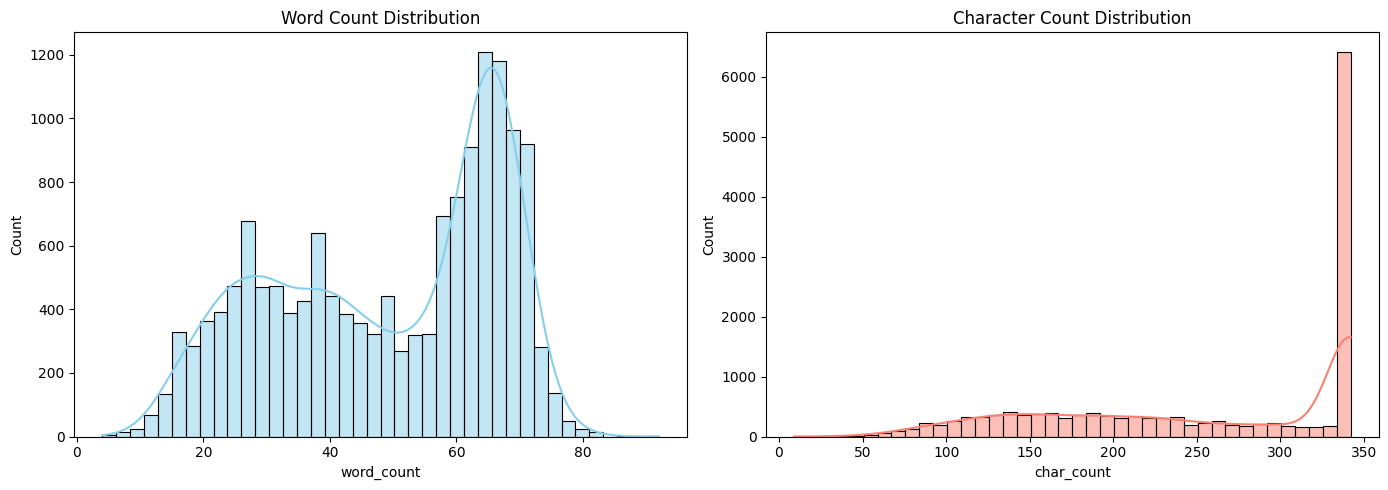

In [10]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], kde=True, bins=40, color='skyblue')
plt.title("Word Count Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df['char_count'], kde=True, bins=40, color='salmon')
plt.title("Character Count Distribution")

plt.tight_layout()
plt.show()

---

### Observations:

1. There are two main plot length styles in the dataset — brief (30–40 words) and extended (60–70 words).
2. A maximum character limit of ~342 is enforced or commonly hit.
3. The dataset mixes single-sentence summaries with multi-sentence overviews.
4. Useful for training models where input size and richness vary, such as in summarization or classification tasks.

In [11]:
# Convert genre strings to lists
df['Genres'] = df['Genres'].apply(ast.literal_eval)

# Count number of unique genres
all_genres = list(itertools.chain.from_iterable(df['Genres']))
unique_genres = set(all_genres)
num_unique_genres = len(unique_genres)

print(num_unique_genres)

28


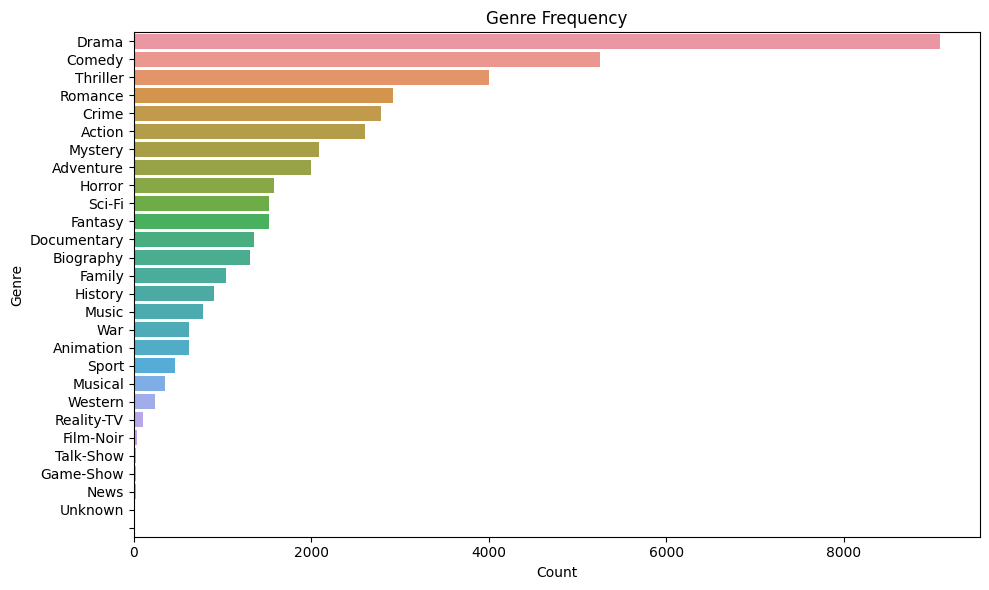

In [12]:
# Plot genre frequency
genre_counts = pd.Series(all_genres).value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Genre Frequency')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


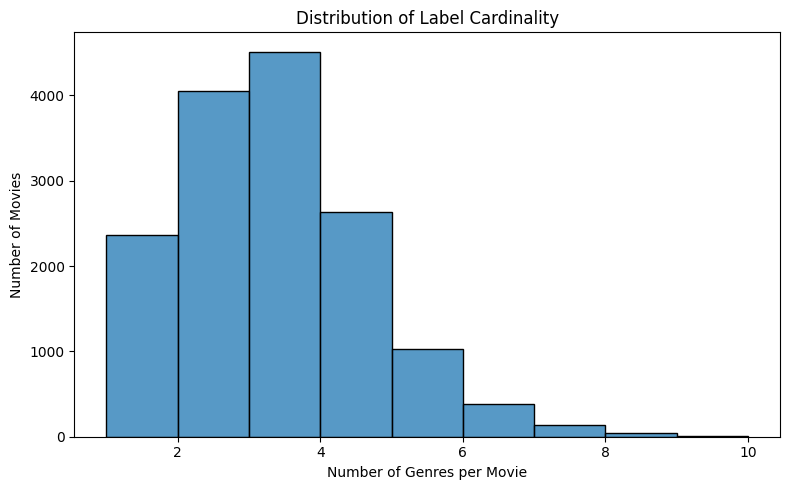

In [13]:
# Distribution of label cardinality (genres per movie)
genre_counts_per_movie = df['Genres'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(genre_counts_per_movie, bins=range(1, genre_counts_per_movie.max()+2), kde=False)
plt.title('Distribution of Label Cardinality')
plt.xlabel('Number of Genres per Movie')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

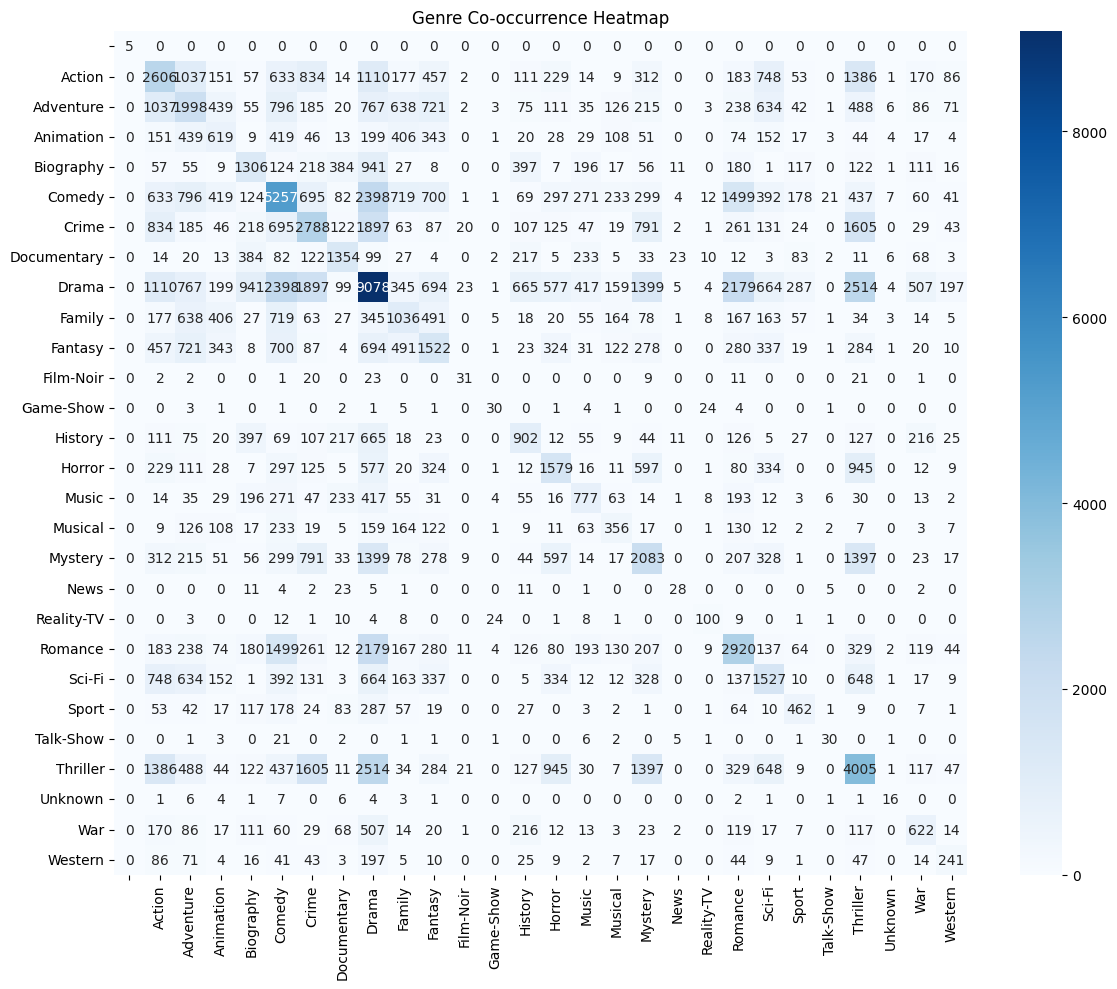

In [14]:
# Visualize genre co-occurrence as heatmap

unique_genres_list = sorted(list(unique_genres)) # Convert set to sorted list for DataFrame compatibility

co_occurrence = pd.DataFrame(0, index=unique_genres_list, columns=unique_genres_list)
for genres in df['Genres']:
    for genre1, genre2 in itertools.combinations_with_replacement(genres, 2):
        co_occurrence.loc[genre1, genre2] += 1
        if genre1 != genre2:
            co_occurrence.loc[genre2, genre1] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues")
plt.title('Genre Co-occurrence Heatmap')
plt.tight_layout()
plt.show()

---


### Observations:

1. There are a total of 14 unique genres
2. Genre frequency: Drama Genre is most often
3. Label cardinality: Most of the movies have 3 genres
4. Genre co-occurrence: Drama is being classified as Drama very often

### Word Cloud / Top N-Grams

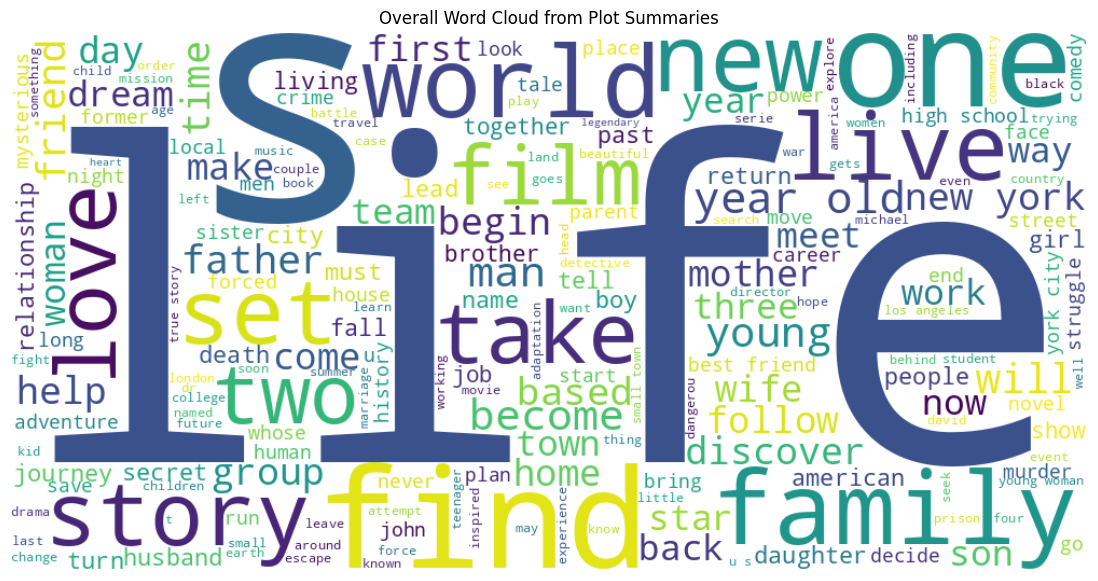

In [15]:
# Combine all plot summaries
combined_text = " ".join(df['Plot_summary'].dropna())

# Generate overall word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(combined_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Overall Word Cloud from Plot Summaries")
plt.show()

In [16]:
# Function to extract top n-grams
def get_top_ngrams(texts, ngram_range=(1, 1), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(texts)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

# Extract top unigrams, bigrams, trigrams
top_unigrams = get_top_ngrams(df['Plot_summary'], (1, 1))
top_bigrams = get_top_ngrams(df['Plot_summary'], (2, 2))
top_trigrams = get_top_ngrams(df['Plot_summary'], (3, 3))

# Combine into a DataFrame for display
top_ngrams_df = pd.DataFrame({
    'Unigrams': [u[0] for u in top_unigrams],
    'Unigram_Freq': [u[1] for u in top_unigrams],
    'Bigrams': [b[0] for b in top_bigrams],
    'Bigram_Freq': [b[1] for b in top_bigrams],
    'Trigrams': [t[0] for t in top_trigrams],
    'Trigram_Freq': [t[1] for t in top_trigrams],
})

top_ngrams_df

,Unigrams,Unigram_Freq,Bigrams,Bigram_Freq,Trigrams,Trigram_Freq
0,life,2450,year old,797,new york city,275
1,new,2185,new york,612,world war ii,106
2,young,1716,high school,355,20th century fox,87
3,world,1621,york city,275,sony pictures classics,77
4,family,1593,los angeles,260,based true story,67
5,story,1485,true story,240,new line cinema,59
6,series,1216,small town,219,year old son,55
7,man,1196,young woman,202,12 year old,52
8,old,1185,best friend,202,premiered originally uk,49
9,year,1172,tells story,183,17 year old,48


---

### Observations:

1. Common words: *life*, *new*, *young*, *world*, *family*, *man*, *love* focuses on **personal journeys**, **relationships**, and **family dynamics** and frequent themes of **youth** and **self-discovery**
2. Top phrases: *year old*, *new york*, *high school*, *los angeles* emphasises on **age/life stage**, **urban settings**, and **school themes**
3. Common trigrams are *new york city*, *world war ii*, *based true story* and plots include **historical events**, **real locations**, and **biographical elements** which mentions of **production companies** suggest some summaries mix marketing content
4. High-frequency verbs/nouns: *find*, *discover*, *follow*, *story*, *family* indicates themes of **transformation**, **search**, and **human-centered stories**
5. Strong presence of **drama**, **family**, **coming-of-age**, **romance**, **action** settings often in **big cities** or **historic periods**

In [17]:
df.to_excel("film_df.xlsx",index  = False)

# Data preparation

In [18]:
df = pd.read_excel("/kaggle/working/film_df.xlsx")
df

,Title,Plot_summary,Genres,word_count,char_count,sentence_count
0,Dekalog (1988),this masterwork by krzysztof kieślowski is one...,['Drama'],55,342,2
1,The Godfather,francis ford coppola's epic features marlon br...,"['Crime', 'Drama']",60,342,2
2,Lawrence of Arabia (re-release),the 40th anniversary re-release of david lean'...,"['Adventure', 'Biography', 'Drama', 'War']",25,144,1
3,The Leopard (re-release),"set in sicily in 1860, luchino visconti's spec...","['Drama', 'History']",44,242,2
4,The Conformist,"set in rome in the 1930s, this re-release of b...",['Drama'],43,249,1
...,...,...,...,...,...,...
15149,Cavemen,"cavemen revolves around joel, his younger brot...","['Comedy', 'Sci-Fi']",67,342,4
15150,Work It,"after they are laid off, lee standish (ben kol...",['Comedy'],35,151,1
15151,Category 7: The End of the World,"""category 7: the end of the world"" picks up wh...","['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Th...",72,340,3
15152,Stalker,lt. beth davis (maggie q) leads the threat ass...,"['Crime', 'Drama', 'Thriller']",49,233,4


In [19]:
# Making single genre from multi genre (Same plot_summary and Title will be present)

df['Genres'] = df['Genres'].apply(ast.literal_eval)
df = df.explode('Genres')

# Remove rows with blank or null genres
df = df[df['Genres'].str.strip() != '']
df = df[df['Genres'].notnull()]

df = df.drop_duplicates(subset='Plot_summary', keep='first')
df

,Title,Plot_summary,Genres,word_count,char_count,sentence_count
0,Dekalog (1988),this masterwork by krzysztof kieślowski is one...,Drama,55,342,2
1,The Godfather,francis ford coppola's epic features marlon br...,Crime,60,342,2
2,Lawrence of Arabia (re-release),the 40th anniversary re-release of david lean'...,Adventure,25,144,1
3,The Leopard (re-release),"set in sicily in 1860, luchino visconti's spec...",Drama,44,242,2
4,The Conformist,"set in rome in the 1930s, this re-release of b...",Drama,43,249,1
...,...,...,...,...,...,...
15149,Cavemen,"cavemen revolves around joel, his younger brot...",Comedy,67,342,4
15150,Work It,"after they are laid off, lee standish (ben kol...",Comedy,35,151,1
15151,Category 7: The End of the World,"""category 7: the end of the world"" picks up wh...",Action,72,340,3
15152,Stalker,lt. beth davis (maggie q) leads the threat ass...,Crime,49,233,4


In [20]:
np.unique(df["Genres"])

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show',
       'Thriller', 'Unknown', 'War', 'Western'], dtype=object)

In [21]:
# Group plot summaries by genre
grouped = df.groupby('Genres')['Plot_summary'].apply(lambda texts: ' '.join(texts))

print(grouped)

Genres
Action         seven samurai (shichinin no samurai) tells the...
Adventure      the 40th anniversary re-release of david lean'...
Animation      a living puppet, with the help of a cricket as...
Biography      in 1431, jeanne d'arc is placed on trial on ch...
Comedy         a silent film production company and cast make...
Crime          francis ford coppola's epic features marlon br...
Documentary    two inner-city chicago boys with hopes of beco...
Drama          this masterwork by krzysztof kieślowski is one...
Family         set in the gloriously vibrant town of cobbleto...
Fantasy        henry spencer tries to survive his industrial ...
Film-Noir      pulp novelist holly martins travels to shadowy...
Game-Show      hosted by alan cummings, 20 contestants (inclu...
History        12 mighty orphans tells the true story of the ...
Horror         a phoenix secretary embezzles $40,000 from her...
Music          spike lee’s adaptation of the broadway show “p...
Musical        in 

In [22]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) # Making a TF-IDF vectorizer
tfidf_matrix = vectorizer.fit_transform(grouped)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped.index, columns=vectorizer.get_feature_names_out()) # A df with TF-IDF values

top_words_per_genre = {} # Top 10 words per genre
for genre in tfidf_df.index:
    top_indices = np.argsort(tfidf_df.loc[genre])[::-1][:10]
    top_words = [(tfidf_df.columns[i], tfidf_df.loc[genre, tfidf_df.columns[i]]) for i in top_indices]
    top_words_per_genre[genre] = top_words

print(top_words_per_genre)

{'Action': [('world', 0.19943485663134644), ('new', 0.1958628890498895), ('life', 0.17494304512161366), ('war', 0.15272048812443206), ('series', 0.13894532390032455), ('man', 0.13872826496836338), ('years', 0.1380200303105427), ('agent', 0.13248268466990923), ('young', 0.13102113913678762), ('action', 0.12205194215772648)], 'Adventure': [('new', 0.2080679696729915), ('young', 0.1851306932306889), ('life', 0.18044044547532517), ('adventure', 0.1719643706202739), ('family', 0.17120199256242452), ('world', 0.16945741859965285), ('story', 0.15217954894437735), ('father', 0.1426809631495456), ('time', 0.13884801992301668), ('year', 0.12766191439696184)], 'Animation': [('animated', 0.3966200164277816), ('world', 0.23223993154650027), ('new', 0.2013955656379807), ('voiced', 0.18789663064105505), ('life', 0.1770456700963849), ('young', 0.16833728626381556), ('family', 0.167797140563768), ('adventure', 0.16050327005929182), ('comedy', 0.15493334640606762), ('story', 0.14021404896424447)], 'Biog

In [23]:
# Print the result
for genre, words in top_words_per_genre.items():
    print(f"\n{genre}:\n" + ", ".join([f"{word} ({score:.3f})" for word, score in words]))


Action:
world (0.199), new (0.196), life (0.175), war (0.153), series (0.139), man (0.139), years (0.138), agent (0.132), young (0.131), action (0.122)

Adventure:
new (0.208), young (0.185), life (0.180), adventure (0.172), family (0.171), world (0.169), story (0.152), father (0.143), time (0.139), year (0.128)

Animation:
animated (0.397), world (0.232), new (0.201), voiced (0.188), life (0.177), young (0.168), family (0.168), adventure (0.161), comedy (0.155), story (0.140)

Biography:
story (0.432), life (0.318), true (0.279), based (0.188), world (0.168), young (0.157), war (0.140), film (0.130), man (0.128), family (0.108)

Comedy:
comedy (0.331), life (0.271), new (0.219), family (0.190), love (0.153), friends (0.152), old (0.137), best (0.136), year (0.133), school (0.132)

Crime:
drama (0.209), crime (0.204), life (0.200), police (0.192), detective (0.184), series (0.177), murder (0.175), young (0.167), new (0.160), family (0.146)

Documentary:
documentary (0.472), film (0.26

---

### Observations:

1. "Life", "New", "Young", and "World" appear frequently across multiple genres — indicating common thematic foundations in storytelling.
2. Genre-specific keywords highlight narrative focus:
   * War: “war”, “ii”, “soldiers”, “army” — strong historical/military emphasis.
   * Romance: “love”, “woman”, “man”, “family” — emotionally driven relationships.
   * Crime & Thriller: “murder”, “detective”, “police”, “mysterious” — classic crime elements.
   * Sci-Fi: “earth”, “future”, “time” — futuristic and speculative themes.
   * Documentary: “documentary”, “film”, “footage”, “interviews” — indicative of real-world storytelling.
3. Character-focused genres:
   * Biography: “true”, “based”, “years”, “man” — emphasizing factual recounts.
   * Animation & Family: “adventure”, “voiced”, “boy”, “girl” — often geared toward younger audiences.
4. Entertainment & Format-driven genres:
   * Game-Show / Reality-TV / Talk-Show: “reality”, “series”, “win”, “daily”, “live” — format-specific vocabulary.
   * Musical / Music: “music”, “band”, “rock”, “musical” — creative performance language.
5. Emotional tone distinction:
   * Comedy: “comedy”, “friends”, “school”, “old” — lighthearted and nostalgic.
   * Horror: “town”, “home”, “night”, “mysterious” — eerie, unsettling settings.
6. Unique standout terms:
   * Western: “sheriff”, “texas”, “town” — regionally specific storytelling.
   * Film-Noir: “woman”, “prove”, “private”, “husband” — classic noir dynamics.

Enlisting important words as features from the plot_summary column

In [24]:
# Fit TF-IDF vectorizer on all plot summaries
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['Plot_summary'])

# Map index to words
feature_names = np.array(vectorizer.get_feature_names_out())

# Extract top N words per row
def extract_top_keywords(row_index, top_n=5):
    row = tfidf_matrix[row_index].toarray().flatten()
    top_indices = row.argsort()[::-1][:top_n]
    return feature_names[top_indices].tolist()

# Apply to all rows and store in a new column
df['important_words'] = [extract_top_keywords(i, top_n=5) for i in range(tfidf_matrix.shape[0])]

# Join into a string to make a readable column
df['important_words'] = df['important_words'].apply(lambda words: ', '.join(words))
df

,Title,Plot_summary,Genres,word_count,char_count,sentence_count,important_words
0,Dekalog (1988),this masterwork by krzysztof kieślowski is one...,Drama,55,342,2,"complex, emotional, person, greatest, originally"
1,The Godfather,francis ford coppola's epic features marlon br...,Crime,60,342,2,"family, oscar, role, near, portrait"
2,Lawrence of Arabia (re-release),the 40th anniversary re-release of david lean'...,Adventure,25,144,1,"peter, david, history, film, food"
3,The Leopard (re-release),"set in sicily in 1860, luchino visconti's spec...",Drama,44,242,2,"ancient, greatest, cinema, international, adap..."
4,The Conformist,"set in rome in the 1930s, this re-release of b...",Drama,43,249,1,"louis, jean, professor, feature, sent"
...,...,...,...,...,...,...,...
15149,Cavemen,"cavemen revolves around joel, his younger brot...",Comedy,67,342,4,"andy, pilot, service, nick, kate"
15150,Work It,"after they are laid off, lee standish (ben kol...",Comedy,35,151,1,"lee, ben, women, men, new"
15151,Category 7: The End of the World,"""category 7: the end of the world"" picks up wh...",Action,72,340,3,"world, rest, nation, threatens, chicago"
15152,Stalker,lt. beth davis (maggie q) leads the threat ass...,Crime,49,233,4,"davis, recent, unit, threat, includes"


In [25]:
df.to_excel("final_df.xlsx",index = False)

# Modeling

In [26]:
#Keeing the relevant columns only

final_df = pd.read_excel("/kaggle/working/final_df.xlsx")

# Display the first few rows and check the relevant columns
final_df[['Plot_summary', 'important_words', 'Genres']].head()

,Plot_summary,important_words,Genres
0,this masterwork by krzysztof kieślowski is one...,"complex, emotional, person, greatest, originally",Drama
1,francis ford coppola's epic features marlon br...,"family, oscar, role, near, portrait",Crime
2,the 40th anniversary re-release of david lean'...,"peter, david, history, film, food",Adventure
3,"set in sicily in 1860, luchino visconti's spec...","ancient, greatest, cinema, international, adap...",Drama
4,"set in rome in the 1930s, this re-release of b...","louis, jean, professor, feature, sent",Drama


In [27]:
# Combine Plot Summary and Important Words
final_df['combined_text'] = final_df['Plot_summary'] + ' ' + final_df['important_words']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(final_df['combined_text'])

# Encode Genres
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(final_df['Genres'])

In [28]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Logisic Regression

In [29]:
# Train Logistic Regression with fast solver
lr_model = LogisticRegression(max_iter=200, solver='saga')
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_preds)
lr_accuracy

0.4953611663353214

In [30]:
unique_labels = np.unique(y_test)
target_names=label_encoder.inverse_transform(unique_labels)
lr_report = classification_report(
    y_test,
    lr_preds,
    labels=unique_labels,
    target_names=target_names,
    output_dict=True
)

for k, v in lr_report.items():
    print(f"{k} : {v}")

Action : {'precision': 0.5119047619047619, 'recall': 0.621900826446281, 'f1-score': 0.5615671641791046, 'support': 484}
Adventure : {'precision': 0.2222222222222222, 'recall': 0.013333333333333334, 'f1-score': 0.025157232704402517, 'support': 150}
Animation : {'precision': 0.6153846153846154, 'recall': 0.13559322033898305, 'f1-score': 0.2222222222222222, 'support': 118}
Biography : {'precision': 0.5106382978723404, 'recall': 0.13793103448275862, 'f1-score': 0.21719457013574664, 'support': 174}
Comedy : {'precision': 0.5148514851485149, 'recall': 0.6860158311345647, 'f1-score': 0.5882352941176472, 'support': 758}
Crime : {'precision': 0.5742574257425742, 'recall': 0.23770491803278687, 'f1-score': 0.33623188405797094, 'support': 244}
Documentary : {'precision': 0.7110091743119266, 'recall': 0.5636363636363636, 'f1-score': 0.6288032454361054, 'support': 275}
Drama : {'precision': 0.41223671013039115, 'recall': 0.6246200607902735, 'f1-score': 0.49667673716012084, 'support': 658}
Family : {

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


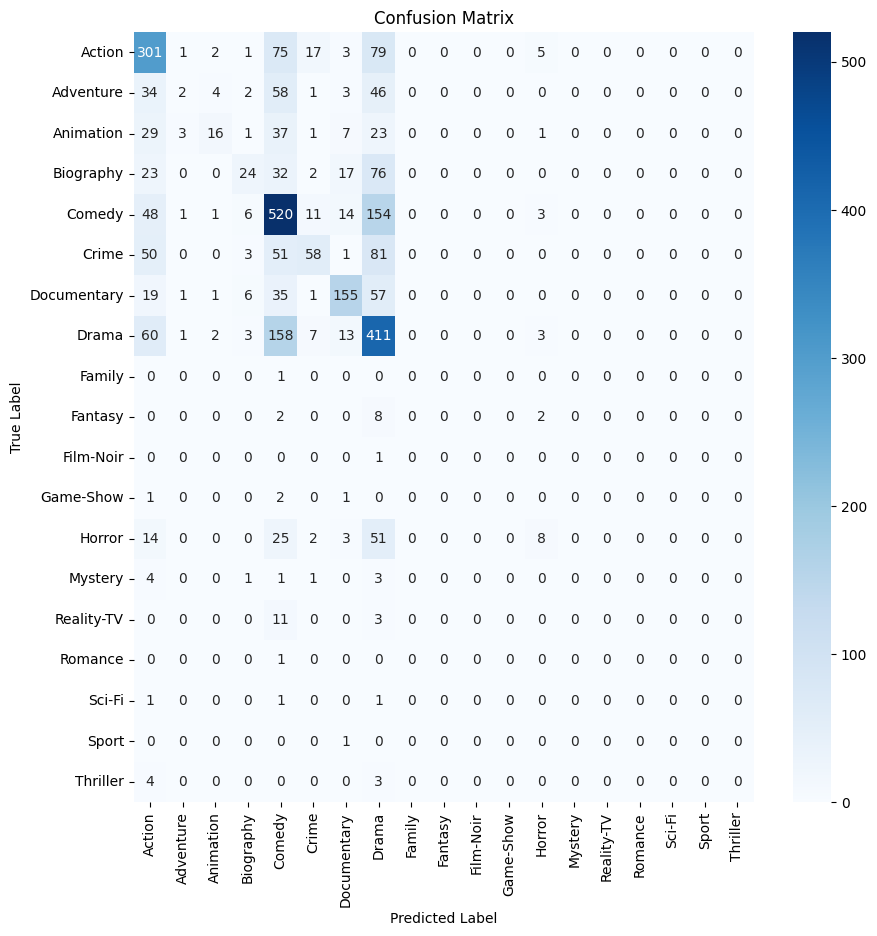

In [31]:
cm = confusion_matrix(y_test, lr_preds) # Confusion matrix
# cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('lr_cf.png')
plt.show()


#### Random Forest Classifier

In [32]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_accuracy

0.4562624254473161

In [33]:
rf_report = classification_report(
    y_test,
    rf_preds,
    labels=unique_labels,
    target_names=label_encoder.inverse_transform(unique_labels),
    output_dict=True
)

for k, v in rf_report.items():
    print(f"{k} : {v}")

Action : {'precision': 0.47424511545293074, 'recall': 0.5516528925619835, 'f1-score': 0.5100286532951289, 'support': 484}
Adventure : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 150}
Animation : {'precision': 0.75, 'recall': 0.1271186440677966, 'f1-score': 0.21739130434782608, 'support': 118}
Biography : {'precision': 0.47368421052631576, 'recall': 0.15517241379310345, 'f1-score': 0.23376623376623376, 'support': 174}
Comedy : {'precision': 0.4692526017029328, 'recall': 0.6543535620052771, 'f1-score': 0.5465564738292011, 'support': 758}
Crime : {'precision': 0.4818181818181818, 'recall': 0.21721311475409835, 'f1-score': 0.2994350282485876, 'support': 244}
Documentary : {'precision': 0.6884422110552764, 'recall': 0.49818181818181817, 'f1-score': 0.5780590717299577, 'support': 275}
Drama : {'precision': 0.378, 'recall': 0.574468085106383, 'f1-score': 0.4559710494571773, 'support': 658}
Family : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}
Fantasy : {'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


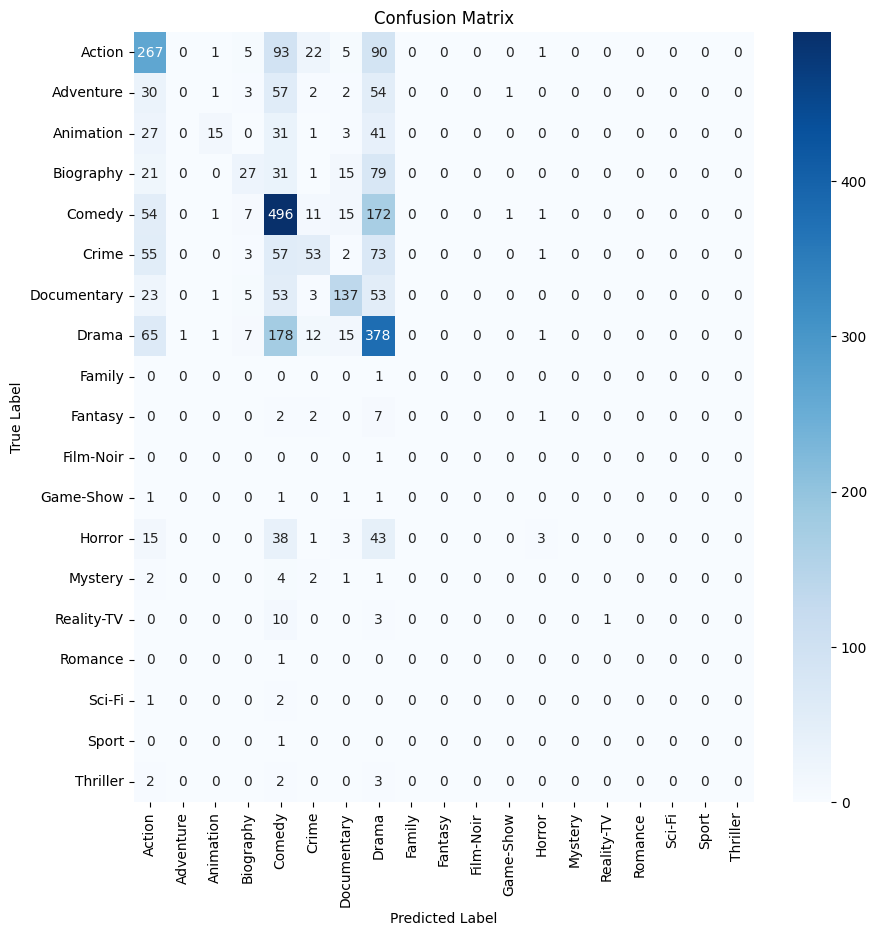

In [34]:
unique_labels = np.unique(y_test)
target_names=label_encoder.inverse_transform(unique_labels)

# Plotting the confusion matrix
cm = confusion_matrix(y_test, rf_preds) # Confusion matrix
# cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('rf_cf.png')
plt.show()


#### Custom Deep Learning Model

In [35]:
#Print the numbers of each class

print(df['Genres'].value_counts())

print()

#create pie chart
numbers = df['Genres'].value_counts()
labels=df['Genres'].value_counts().index


Genres
Comedy         3820
Drama          3456
Action         2426
Documentary    1345
Crime          1194
Biography       823
Adventure       631
Animation       603
Horror          524
Fantasy          63
Reality-TV       48
Thriller         34
Mystery          33
Game-Show        20
Sci-Fi           14
Romance          11
Family           10
Unknown           6
Musical           6
Music             5
Film-Noir         4
Western           4
Talk-Show         2
History           1
War               1
Sport             1
News              1
Name: count, dtype: int64



In [36]:
#Dropping less frequent rows (fewer than 10 entries)

# Count genre frequencies
genre_counts = final_df['Genres'].value_counts()

# Filter out genres with less than 10 entries
valid_genres = genre_counts[genre_counts >= 10].index
df = final_df[final_df['Genres'].isin(valid_genres)].reset_index(drop=True)

# Display trimmed value counts
df['Genres'].value_counts()

Genres
Comedy         3820
Drama          3456
Action         2426
Documentary    1345
Crime          1194
Biography       823
Adventure       631
Animation       603
Horror          524
Fantasy          63
Reality-TV       48
Thriller         34
Mystery          33
Game-Show        20
Sci-Fi           14
Romance          11
Family           10
Name: count, dtype: int64

In [37]:
X = df['Plot_summary']
y = df['Genres']

In [38]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [39]:
label_encoder = LabelEncoder() # Initialize the LabelEncoder

# Both learns the mapping and transforms the y_train labels accordingly.
y_train = label_encoder.fit_transform(y_train) 

# Applies the same mapping learned from the train train split to other splits to ensure consistent encoding
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Converting the integer-encoded labels into one-hot encoded format
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [40]:
#Cleaning text further

def preprocess_text(text):
    text = text.lower() #ensures that the text is uniform in case
    text = re.sub(r'(covid[-_]?19|covid2019|covid[-_]?2019|corona[-_]?virus|corona|covid)', 'covid', text) #normalization to reduce variance in texts/terms
    text = re.sub(r'http\S+', '', text) #eliminate web links from the text
    text = re.sub(r'@\w+', '', text) # removes any social media handles
    text = re.sub(r'#', '', text) #removes any hashtags from texts
    text = re.sub(r'\n', ' ', text) #removes any new lines from the texts
    text = re.sub(r'\t', ' ', text) #replaces any tab characters with a space
    text = re.sub(r'\r', ' ', text) #replaces any carriage return characters with a space
    text = re.sub(r'â|â’', "'", text) #replaces any specific characters appearing due to encoding issues with an apostrophe
    text = re.sub(r'\x92|\xa0|\x85|\x95', '', text) #removes various unwanted characters appearing due to encoding artifacts
    text = contractions.fix(text) # expands shortened words using the contractions library
    text = re.sub(r'[^\w\s]', ' ', text) # removes all characters that are not word characters or whitespace
    return text #returns the cleaned and processed text

In [41]:
X_train = np.array([preprocess_text(text) for text in X_train])
X_val = np.array([preprocess_text(text) for text in X_val])
X_test = np.array([preprocess_text(text) for text in X_test])

In [42]:
# Tokenizing the texts

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)
word_counts = len(tokenizer.word_index) + 1  # vocabulary size
print("Numbers of unique words present in the TRAIN split:", word_counts)

# print()

# tokenizer_test  = Tokenizer(filters='')
# tokenizer_test.fit_on_texts(X_val)
# word_counts_test = len(tokenizer_test.word_index) + 1  # vocabulary size
# print("Numbers of unique words present in the TEST split:", word_counts_test)

# print()

# tokenizer_val = Tokenizer(filters='')
# tokenizer_val.fit_on_texts(X_val)
# word_counts_val = len(tokenizer_val.word_index) + 1  # vocabulary size
# print("Numbers of unique words present in the VALID split:", word_counts_val)

Numbers of unique words present in the TRAIN split: 34610


In [43]:
#Vectorizing the text


train_sequences = tokenizer.texts_to_sequences(X_train)

maxlen = max([len(seq) for seq in train_sequences])
print("Maximum length of all sequences:", maxlen)

Maximum length of all sequences: 73


In [44]:
# Padding the sequences (Post-padding the sequences)

padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
print("Padded TRAINING Sequences Shape:", padded_train_sequences.shape)

Padded TRAINING Sequences Shape: (12044, 73)


In [45]:
padded_train_sequences

array([[    1,   171,   155, ...,     0,     0,     0],
       [  171,    68,  2923, ...,     0,     0,     0],
       [    2, 19177,  2808, ...,     0,     0,     0],
       ...,
       [10233,   419,     1, ...,     0,     0,     0],
       [    1,  1903,   118, ...,     0,     0,     0],
       [10083,  6736,  6150, ...,     0,     0,     0]], dtype=int32)

In [46]:


longest_sequence_index = np.argmax([len(seq) for seq in train_sequences])

# Get the longest sequence and its corresponding original sentence
longest_sequence = train_sequences[longest_sequence_index]
longest_sentence = X_train[longest_sequence_index]

print(f"Longest sequence index: \n{longest_sequence_index}")
print()
print(f"Longest sequence: \n{longest_sequence}")
print()
print(f"Longest sequence length: \n{len(longest_sequence)}")
print()
print(f"Longest sentence: \n{longest_sentence}")



Longest sequence index: 
1905

Longest sequence: 
[5126, 7, 2, 5900, 767, 20, 30, 173, 233, 1, 2196, 70, 3, 1529, 1480, 6, 8, 23, 22, 17, 169, 17, 343, 56, 55, 154, 5, 164, 17, 306, 5, 1375, 80, 1, 328, 3, 1, 219, 5, 7073, 60, 17, 7, 3987, 17, 54, 49, 1260, 5, 1627, 12, 8, 90, 2052, 28, 396, 1, 122, 17, 169, 21, 128, 102, 123, 204, 683, 23, 102, 55, 1388, 5, 164, 36]

Longest sequence length: 
73

Longest sentence: 
rex is a cab driver who has never left the mining town of broken hill in his life  when he discovers he does not have long to live  he decides to drive through the heart of the country to darwin  where he is heard he will be able to die on his own terms  but along the way he discovers that before you can end your life you have got to live it   


In [47]:
# For Validation set
val_sequences = tokenizer.texts_to_sequences(X_val)
padded_val_sequences = pad_sequences(val_sequences, maxlen=maxlen, padding='post')

print("Padded VALIDATION Sequences Shape:", padded_val_sequences.shape)

Padded VALIDATION Sequences Shape: (1505, 73)


In [48]:
# For test set
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

print("Padded TEST Sequences Shape:", padded_test_sequences.shape)

Padded TEST Sequences Shape: (1506, 73)


In [49]:
# Creating the Embedding matrix using GloVe embedding

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix




embedding_dim = 100
filepath = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embedding_matrix = create_embedding_matrix(filepath, tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Percent of vocabulary covered: {round(nonzero_elements/word_counts*100, 2)}%")

Percent of vocabulary covered: 92.21%


In [50]:
# Get the words that are not covered by GloVe
not_covered_words = []
for word, idx in tokenizer.word_index.items():
    if np.count_nonzero(embedding_matrix[idx]) == 0:  # If the embedding vector is all zeros
        not_covered_words.append(word)

# Print some of the words that are not covered
print(f"Total uncovered words: {len(not_covered_words)}")
print()
print("Sample of uncovered words:", not_covered_words[:50])

Total uncovered words: 2695

Sample of uncovered words: ['acirc', 'covid', 'jaeden', 'haddish', 'britbox', 'vikander', 'kumail', 'nanjiani', 'stre', 'throu', 'docuseries', 'roiland', 'daveed', 'lakeith', 'mulaney', 'parvana', 'reynor', 'negga', 'exarchopoulos', 'awkwafina', 'mahershala', 'thomasin', 'boutella', 'rosow', 'minhee', 'schoenaerts', '64257', 'nélisse', 'horri', 'dangero', 'krieps', 'demián', 'caestecker', 'vanderham', 'boyega', 'qualley', 'hirut', 'impos', 'polaha', 'ansiedad', 'efira', 'americ', 'erivo', 'astrof', 'documentry', 'ménochet', 'delevingne', 'konkle', 'maslany', 'raffey']


---


The Dataset is ready to be fed to the neural network upto this point.

    Train features = padded_train_sequences

    Train target = y_train

    Validation features = padded_val_sequences

    Validation target = y_val

    Test features = padded_test_sequences

    Test target = y_test



In [51]:
print(padded_train_sequences)  # training feature
print(y_train)  # training target

print()
print("=========================================================")
print()

print(len(padded_train_sequences))  # training feature length
print(len(y_train))  # training target length

[[    1   171   155 ...     0     0     0]
 [  171    68  2923 ...     0     0     0]
 [    2 19177  2808 ...     0     0     0]
 ...
 [10233   419     1 ...     0     0     0]
 [    1  1903   118 ...     0     0     0]
 [10083  6736  6150 ...     0     0     0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


12044
12044


In [52]:
# Creating the model



clear_session ()

model = Sequential()

model.add(Embedding(word_counts,                   # using the pre-trained embedding matrix for word embeddings
                    embedding_dim,                       # convert each word in a sequence to a dense vector of size embedding_dim
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.3)) # dropout to the embedding layer to prevent overfitting (randomly drops entire feature maps rather than individual elements)

model.add(Bidirectional(LSTM(units=64, return_sequences=True))) # bidirectional LSTM layer has 64 units and outputs sequence
model.add(BatchNormalization()) # stabilizing and accelerating the training by normalizing each layer’s input
model.add(Dropout(0.25)) 

model.add(Bidirectional(LSTM(units=32, return_sequences=False))) # bidirectional LSTM layer has 32 units and outputs sequence
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.05))) # This dense layer consisting of 24 neurons with ReLU activation functions process the LSTM outputs
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05))) # This dense layer consisting of 16 neurons with ReLU activation functions process the LSTM outputs
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(17, activation='softmax')) # output layer of 5 neurons for 5 classes ; softmax activation to output the class with maximum probability 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
# Model Architecture

model.build((padded_train_sequences.shape))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (12044, 73, 100)            │       3,461,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (12044, 73, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (12044, 73, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (12044, 73, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (12044, 73, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (12044, 64)                 │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (12044, 64)                 │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (12044, 64)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (12044, 24)                 │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (12044, 24)                 │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (12044, 24)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (12044, 16)                 │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (12044, 16)                 │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (12044, 16)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (12044, 17)                 │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,589,873 (13.69 MB)

 Trainable params: 3,589,409 (13.69 MB)

 Non-trainable params: 464 (1.81 KB)

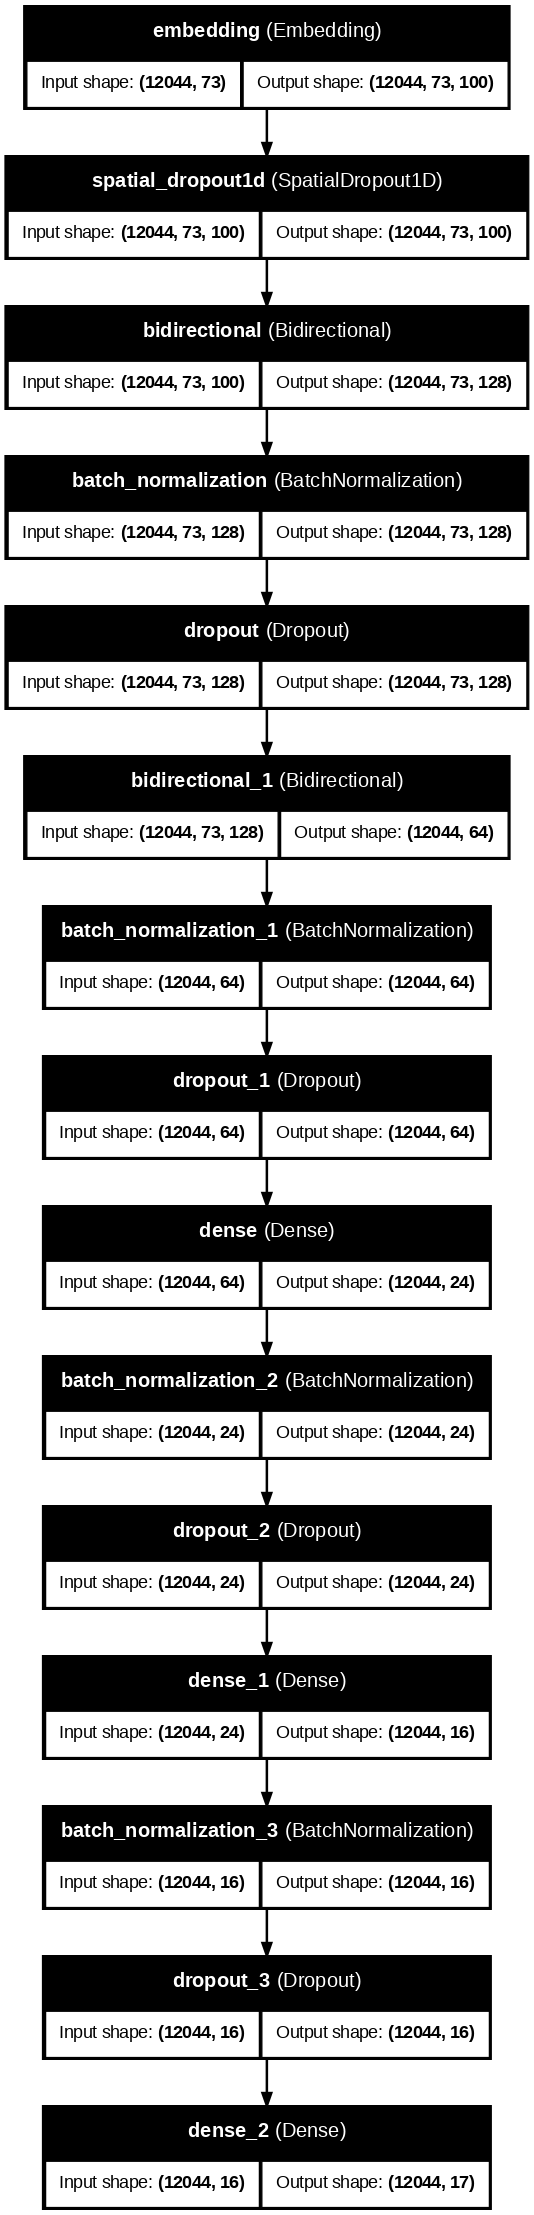

In [54]:
# Visualizing the model architecture

plot_model(model, show_shapes=True, show_layer_names=True, dpi=90)

---


Setting up the relevant training elements and tuning the hyperparameters

verbose=1: povides a detailed output with progress bars, metrics for each epoch, and any additional callback messages

verbose=0: no progress bars or messages will be shown

verbose=2: shows only one line per epoch with epoch and metric updates but no progress bar



In [55]:
y_train_original = np.argmax(y_train, axis=1)  # Converting one-hot encoded y_train back to label form

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original) # calculates the weight for each class based on its frequency
class_weights = dict(enumerate(class_weights))

num_epochs = 200 # setting up epoch numbers

reduce_lr = ReduceLROnPlateau( # reduces the learning rate f the val_loss does not improve 
    monitor='val_loss',
    factor=0.2, # reduces the learning rate by a factor of 0.2 if......
    patience=3, # ......if the val_loss does not improve for 3 consecutive epochs
    min_lr=1e-6,# the minimum threshold for the learning rate
    verbose=1
)

checkpoint = ModelCheckpoint( # saves the model weights whenever val_accuracy improves
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True, # ensures that only the best weights are saved based on validation accuracy
    mode='max',
    verbose=1 
)

early_stop = EarlyStopping(monitor='val_loss', patience=10) # monitors the val_loss and stops training if it doesn’t improve for 10 consecutive epochs 

In [56]:
model.compile(loss = 'categorical_crossentropy', # calculates the loss by comparing the model’s predicted probabilities to the one-hot-encoded true labels
              optimizer=Adam(learning_rate=0.000001, clipnorm=1.0), # clipnorm=1.0 prevents the gradients from growing too large by capping their norm to 1
              metrics = ['accuracy']) # evaluation metric during training

In [57]:
history = model.fit(padded_train_sequences, # input sequences
                    y_train, # output labels of those input sequences
                    validation_data=(padded_val_sequences, y_val), # validation data and labels
                    epochs=num_epochs, #epoch numbers
                    class_weight=class_weights, # counteracts class imbalance by adjusting the model’s loss calculation by giving different weights to each class
                    callbacks =[reduce_lr, early_stop, checkpoint], # applies the learning rate scheduler, model checkpointing, and early stopping during training
                    batch_size=32, # the number of samples processed before updating the model weights
                    verbose=1)

Epoch 1/200
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0426 - loss: 5.9853
Epoch 1: val_accuracy improved from -inf to 0.02924, saving model to best_model.keras
377/377 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.0426 - loss: 5.9856 - val_accuracy: 0.0292 - val_loss: 5.9831 - learning_rate: 1.0000e-06
Epoch 2/200
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0436 - loss: 6.0199
Epoch 2: val_accuracy did not improve from 0.02924
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.0436 - loss: 6.0202 - val_accuracy: 0.0259 - val_loss: 5.8250 - learning_rate: 1.0000e-06
Epoch 3/200
376/377 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0484 - loss: 6.1952
Epoch 3: val_accuracy did not improve from 0.02924
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.0484 - loss: 6.1944 - val_accuracy: 0.0252 - val_loss: 5.8031 - learning_rate: 1.0000e-06
Epoch 4/200
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0470 - loss: 6.1555
Epoch 4: val_accuracy

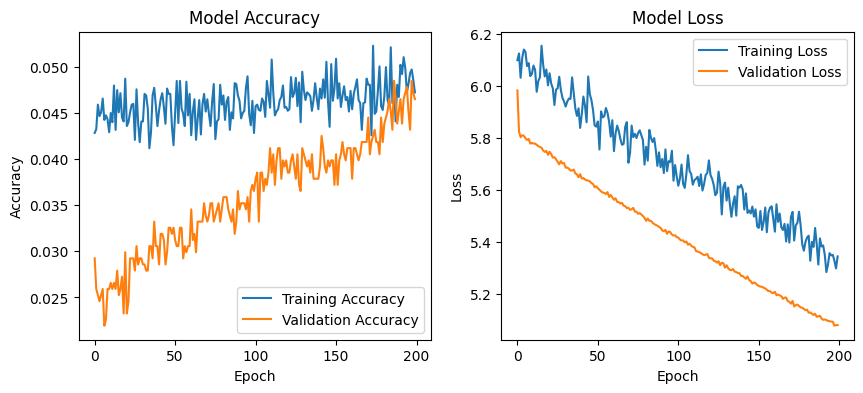

In [58]:
# Training perfermance report

plt.rcParams['figure.figsize'] = (10, 4)

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
# Saving the model

model.save('final_model.h5')


# Load the model from the file

model = load_model('/kaggle/working/final_model.h5')

In [60]:
# Testing the custom model's accuracy
test_loss, test_accuracy = model.evaluate(padded_test_sequences, y_test, verbose=1)
print(f'Test Accuracy: {(test_accuracy * 100):.2f}%')



48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0605 - loss: 5.0921
Test Accuracy: 5.78%


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


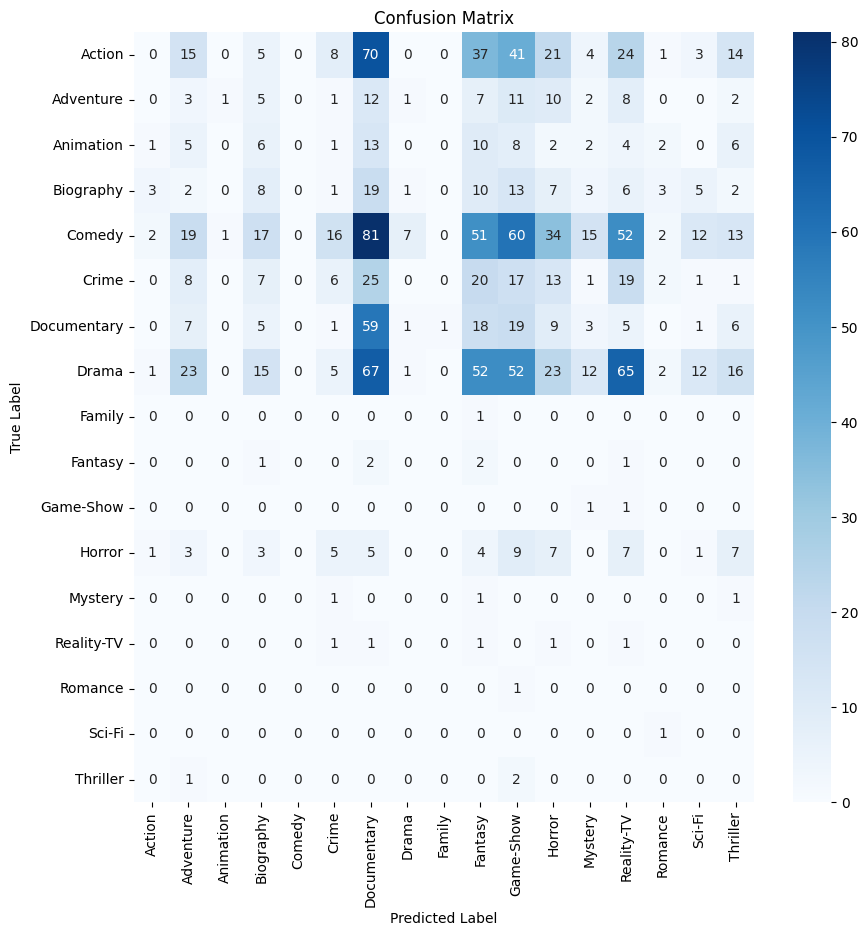

In [61]:
# Plotting the confusion matrix

y_pred = np.argmax(model.predict(padded_test_sequences), axis=-1) # Predict the labels for test data
y_true = np.argmax(y_test, axis=-1)

class_names = label_encoder.classes_

cm = confusion_matrix(y_true, y_pred) # Confusion matrix
# cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('cm_cf.png')
plt.show()



In [62]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00       243
   Adventure       0.03      0.05      0.04        63
   Animation       0.00      0.00      0.00        60
   Biography       0.11      0.10      0.10        83
      Comedy       0.00      0.00      0.00       382
       Crime       0.13      0.05      0.07       120
 Documentary       0.17      0.44      0.24       135
       Drama       0.09      0.00      0.01       346
      Family       0.00      0.00      0.00         1
     Fantasy       0.01      0.33      0.02         6
   Game-Show       0.00      0.00      0.00         2
      Horror       0.06      0.13      0.08        52
     Mystery       0.00      0.00      0.00         3
  Reality-TV       0.01      0.20      0.01         5
     Romance       0.00      0.00      0.00         1
      Sci-Fi       0.00      0.00      0.00         1
    Thriller       0.00      0.00      0.00         3

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
